# Processing data
Available at https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [114]:
import os
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import librosa

import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from IPython.display import Audio

In [3]:
AUDIO_ROOT = './data/audio'
SAMPLE_LENGTH_MS = 4000

## Helpers for loading and transforming the data

In [ ]:
# TODO: Split audio into equal length segments and make each a file

In [56]:
files = []
labels = []
for dirent in os.listdir(AUDIO_ROOT):
    dirpath = os.path.join(AUDIO_ROOT, dirent)
    if os.path.isdir(dirpath):
        for file in os.listdir(dirpath):
            path = os.path.join(dirpath, file)
            files.append(path)
            labels.append(dirent)

data = pd.DataFrame({'file': files, 'label': labels})
data['labelId'] = data.groupby('label', sort=False).ngroup()
data

,file,label,labelId
0,./data/audio/pop/pop.00027.wav,pop,0
1,./data/audio/pop/pop.00033.wav,pop,0
2,./data/audio/pop/pop.00032.wav,pop,0
3,./data/audio/pop/pop.00026.wav,pop,0
4,./data/audio/pop/pop.00030.wav,pop,0
...,...,...,...
995,./data/audio/jazz/jazz.00018.wav,jazz,9
996,./data/audio/jazz/jazz.00032.wav,jazz,9
997,./data/audio/jazz/jazz.00026.wav,jazz,9
998,./data/audio/jazz/jazz.00027.wav,jazz,9


In [78]:
class AudioHelper():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    # Convert into 2-channel
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))

    # Since Resample applies to a single channel, we resample one channel at a time
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

In [88]:
class AudioTransformations():
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # Generate a Mel Spectrogram 
    # It converts the audio file into a format that is more similar to how humans actually percieve audio
    @staticmethod
    def spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    @staticmethod
    def spectrogram_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

## Visualizers

In [112]:
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#preparing-data-and-utility-functions-skip-this-section
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

## Creating PyTorch data loader

In [89]:
class AudioDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 4000 # Truncating all audio clips to 4 seconds
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'file']
        class_id = self.df.loc[idx, 'labelId']

        aud = AudioHelper.open(audio_file)
        reaud = AudioHelper.resample(aud, self.sr)
        rechan = AudioHelper.rechannel(reaud, self.channel)
        # TODO: Instead of truncating can we make multiple samples from a single piece
        dur_aud = AudioHelper.pad_trunc(rechan, self.duration)
        
        shift_aud = AudioTransformations.time_shift(dur_aud, self.shift_pct)
        sgram = AudioTransformations.spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioTransformations.spectrogram_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

In [90]:
dataset = AudioDS(data)

# Random split of 80:20 between training and validation
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [98]:
d = next(iter(train_dl))

TypeError: Invalid shape (2, 64, 344) for image data

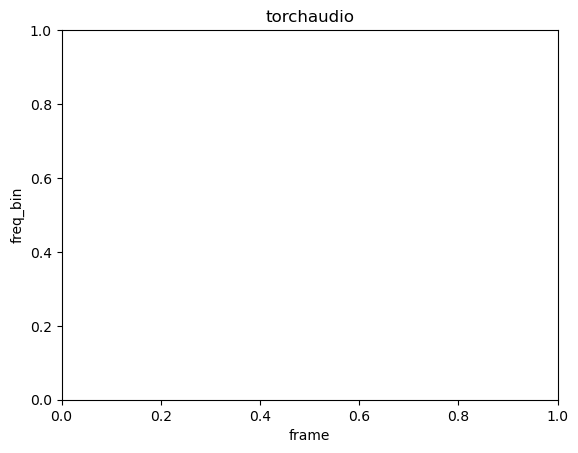

In [115]:
plot_spectrogram(d[0][0], title='torchaudio')

# Model